In [1]:
import bisect
import time
from itertools import product

import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder

## Preparación del dataset

### Adaptar el dataset

In [2]:
df = pd.read_csv('../data/data_engineered.csv')

In [3]:
df = df.drop(columns=['first', 'last', 'city_pop', 'street', 'job', 'dob', 'trans_num', 'hour_window', 'unix_time'])

### Separación de la data 

In [4]:
train_mask = (df['trans_month'] == 12) & (df['year'] == 2020)
df_train = df[~train_mask]

df_test = df[((df['trans_month'] == 12) & (df['year'] == 2020))]

In [5]:
X_train = df_train.drop(columns=['is_fraud'])
y_train = df_train['is_fraud']

X_test = df_test.drop(columns=['is_fraud'])
y_test = df_test['is_fraud']

In [6]:
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
numerical_cols = X_train.select_dtypes(include=np.number).columns

In [7]:
categorical_cols

Index(['merchant', 'category', 'gender', 'city', 'state'], dtype='object')

In [8]:
numerical_cols

Index(['cc_num', 'amt', 'zip', 'lat', 'long', 'merch_lat', 'merch_long',
       'amt_month', 'amt_year', 'amt_month_shopping_net_spend',
       'count_month_shopping_net', 'dist_between_client_and_merch',
       'trans_month', 'trans_day', 'hour', 'year', 'times_shopped_at_merchant',
       'times_shopped_at_merchant_year', 'times_shopped_at_merchant_month',
       'times_shopped_at_merchant_day', 'time_diff_seconds', 'trans_per_hour',
       'hour_trans_ratio', 'unusual_distance', 'distance_diff',
       'velocity_km_h', 'mean_dist_merchant', 'std_dist_merchant',
       'dist_z_score', 'amt_month_ratio', 'amt_year_ratio',
       'mean_amt_category', 'std_amt_category', 'amt_z_score',
       'high_amt_first_time', 'mean_times_day_merchant',
       'std_times_day_merchant', 'times_day_z_score', 'unique_cards_per_hour',
       'amt_variance_hour'],
      dtype='object')

In [9]:
X_train_processed = X_train.copy()
X_test_processed = X_test.copy()

In [10]:
for col in categorical_cols:
    le = LabelEncoder()
    # Fit on training data and transform both train and test
    X_train_processed[col] = le.fit_transform(X_train[col].astype(str)) # Ensure string type

    # Handle new/unseen categories in test data
    # Map them to a placeholder that will be included in the encoder's classes
    X_test_processed[col] = X_test[col].astype(str).map(lambda s: '<unknown>' if s not in le.classes_ else s)
    
    if '<unknown>' not in le.classes_:
        # Add '<unknown>' to the LabelEncoder's classes if it's not already there
        # and it appeared in the test set after mapping
        if X_test_processed[col].eq('<unknown>').any():
            le_classes = le.classes_.tolist()
            bisect.insort_left(le_classes, '<unknown>') # Keep sorted for consistency
            le.classes_ = np.array(le_classes)
        
    X_test_processed[col] = le.transform(X_test_processed[col])

## Primer Intento

Definimos los parámetros para nuestro modelo

In [11]:
lgbm_classifier = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    objective='binary',
    random_state=123,
    n_jobs=2,
    is_unbalance=True
)

Entrenamos el modelo que definimos con la data de entrenamiento

In [12]:
lgbm_classifier.fit(X_train_processed, y_train)

[LightGBM] [Info] Number of positive: 9393, number of negative: 1703463
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7132
[LightGBM] [Info] Number of data points in the train set: 1712856, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005484 -> initscore=-5.200454
[LightGBM] [Info] Start training from score -5.200454


LGBMClassifier(is_unbalance=True, n_jobs=2, objective='binary',
               random_state=123)

Obtenemos las predicciones del modelo entrenado utilizando los datos de prueba

In [13]:
y_pred_lgbm = lgbm_classifier.predict(X_test_processed)
y_pred_proba_lgbm = lgbm_classifier.predict_proba(X_test_processed)[:, 1]

Comparamos los resultados de las predicciones

LightGBM Model Evaluation:


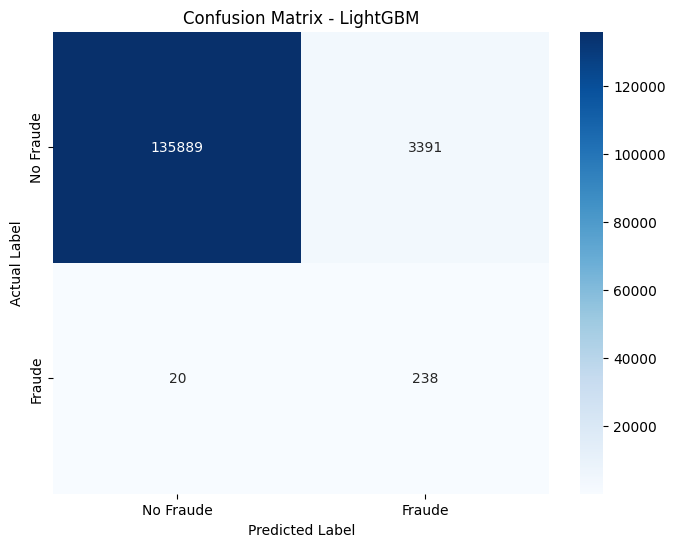

In [14]:
print("LightGBM Model Evaluation:")
cm = confusion_matrix(y_test, y_pred_lgbm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fraude', 'Fraude'], yticklabels=['No Fraude', 'Fraude'])
plt.title('Confusion Matrix - LightGBM')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


En la gráfica se puede ver que nuestro modelo es muy bueno sabiendo cuando una transacción es no fraude, sin embargo, se puede ver que también tiende a confundir algunas transacciones como fraude cuando no lo son. cuando vemos la clasificación de las transacciones fraudulentas, podemos ver que nuestras si lográ identificar un 93% de las transacciones fraudulentas, lo cual es menos del 7% para errores de tipo 2. En cambio, cuando miramos los errores de tipo 1, se puede ver que nuestro modelo no parece reconocer muy bien los fraudes, ya que nos devuelve muchas transacciones legítimas como fraudulentas.

In [15]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lgbm, target_names=['Not Fraud', 'Fraud']))

print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_pred_proba_lgbm))

print("\nF1 Score:")
print(f1_score(y_test, y_pred_lgbm, average='weighted'))



Classification Report:
              precision    recall  f1-score   support

   Not Fraud       1.00      0.98      0.99    139280
       Fraud       0.07      0.92      0.12       258

    accuracy                           0.98    139538
   macro avg       0.53      0.95      0.56    139538
weighted avg       1.00      0.98      0.99    139538


ROC AUC Score:
0.9713363633125398

F1 Score:
0.9860052643388397


In [16]:
print("\nFeature Importances (LightGBM):")
importances = lgbm_classifier.feature_importances_
feature_names = X_train_processed.columns
sorted_indices = np.argsort(importances)[::-1]

for i in sorted_indices:
    print(f"{feature_names[i]}: {importances[i]}")


Feature Importances (LightGBM):
amt: 311
amt_z_score: 305
hour_trans_ratio: 191
mean_times_day_merchant: 176
std_times_day_merchant: 156
amt_month_shopping_net_spend: 155
amt_month_ratio: 150
amt_year_ratio: 145
amt_year: 135
amt_month: 113
hour: 112
time_diff_seconds: 110
times_day_z_score: 70
velocity_km_h: 57
city: 53
cc_num: 48
category: 47
std_dist_merchant: 46
mean_dist_merchant: 45
merchant: 45
times_shopped_at_merchant: 44
mean_amt_category: 41
count_month_shopping_net: 39
distance_diff: 35
merch_lat: 35
dist_between_client_and_merch: 32
dist_z_score: 30
state: 30
zip: 30
lat: 29
trans_per_hour: 26
trans_month: 25
long: 21
std_amt_category: 21
times_shopped_at_merchant_year: 17
merch_long: 16
amt_variance_hour: 15
times_shopped_at_merchant_day: 12
trans_day: 10
year: 6
gender: 5
times_shopped_at_merchant_month: 5
unique_cards_per_hour: 3
high_amt_first_time: 2
first_time_at_merchant: 1
unusual_distance: 0


Imprimimos las features más importantes dentro de las predicciones del modelo

## Métricas Personalizadas

In [17]:
# Crear datasets de LightGBM
train_data = lgb.Dataset(X_train_processed, label=y_train)
test_data = lgb.Dataset(X_test_processed, label=y_test, reference=train_data)

### Métrica usando cantidad de tarjetas y varianza en la cantidad por hora

In [18]:
# Configurar parámetros
params = {
    'objective': 'binary', # Definimos el objetivo de clasificación binaria
    'metric': 'precision', # Definimos la métrica de evaluación a binar logloss por nuestro objetivo
    'learning_rate': 0.01, # Definimos la tasa de aprendizaje
    'num_leaves': 31, # Definimos el número de hojas de nuestros árboles
    'max_depth': 10, # Definimos la profundidad máxima de nuestros árboles
    'seed': 321, # Definimos la semilla para guardar el estado aleatorio
    'feature_fraction': 0.6, # Definimos la fracción de características a usar en cada iteración (estas son seleccionadas aleatoriamente)
    'lambda_l1': 0.8, # Definimos la regularización L1
    'lambda_l2': 0.5, # Definimos la regularización L2
    'is_unbalance': True, # Le indicamos al modelo que el dataset está desbalanceado
    'boosting_type': 'dart', # Definimos el tipo de boosting a usar (utilizamos DART, ya que es una opción más robusta, aunque más costosa y lenta al momento de entrenar datos)
    'num_threads': 4, # Definimos el número de hilos a usar para realizar el entrenamiento
}

In [19]:
def custom_coordinated_attack_metric(preds, dataset):
    """
    Función personalizada para evaluar la efectividad del modelo 
    en la detección de ataques coordinados.
    
    Un ataque coordinado típicamente implica:
    1. Múltiples tarjetas usadas en periodos cortos (unique_cards_per_hour alto)
    2. Patrones similares de gastos (amt_variance_hour bajo o muy alto)
    3. Múltiples transacciones en comercios similares
    """
    # Obtenemos las etiquetas verdaderas
    labels = dataset.get_label()
    
    # Convertimos las predicciones a clases binarias
    preds_binary = np.where(preds > 0.5, 1, 0)
    
    # Si el dataset tiene índice, podemos recuperar features específicas
    # Esto asume que las columnas están en este orden - ajusta según sea necesario
    try:
        # Intentamos obtener las características relevantes para ataques coordinados
        unique_cards_idx = list(X_train_processed.columns).index('unique_cards_per_hour')
        amt_variance_idx = list(X_train_processed.columns).index('amt_variance_hour')
        
         # Acceder a los datos originales
        data_to_use = X_train_processed if dataset.reference is None else X_test_processed
        
        unique_cards = data_to_use['unique_cards_per_hour'].values
        amt_variance = data_to_use['amt_variance_hour'].values
        
        # Identificar posibles ataques coordinados (umbral arbitrario, ajustar según análisis)
        potential_coordinated_attacks = (unique_cards > unique_cards.mean() + 2*unique_cards.std()) | \
                                       (amt_variance < amt_variance.mean() - 2*amt_variance.std())
        
        # Calcular métricas específicas para ataques coordinados
        true_pos_coord = np.sum((labels == 1) & (preds_binary == 1) & potential_coordinated_attacks)
        false_neg_coord = np.sum((labels == 1) & (preds_binary == 0) & potential_coordinated_attacks)
        
        # Penalizar fuertemente los falsos negativos en ataques coordinados
        if true_pos_coord + false_neg_coord > 0:
            coordinated_recall = true_pos_coord / (true_pos_coord + false_neg_coord)
        else:
            coordinated_recall = 1.0  # No hay casos de ataques coordinados
            
        # Métrica general (ponderamos más los errores en ataques coordinados)
        error = np.mean(preds_binary != labels)
        weighted_error = error * 0.3 + (1 - coordinated_recall) * 0.7
        
        return 'coordinated_attack_metric', weighted_error, False
        
    except (ValueError, IndexError):
        # Calculamos la métrica personalizada: FN / (TP + FN) en caso de error
        true_positives = np.sum((labels == 1) & (preds_binary == 1))
        false_negatives = np.sum((labels == 1) & (preds_binary == 0))
        
        if true_positives == 0:
            ratio = float('inf')  # Si no hay TP, la métrica es infinita (muy mala)
        else:
            ratio = (true_positives + false_negatives) / true_positives
            
        return 'coordinated_attack_metric', ratio, False  # False porque una tasa menor es mejor

In [20]:
# Entrenar el modelo con la métrica personalizada
model = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    valid_sets=[train_data, test_data],
    feval=custom_coordinated_attack_metric # Colocamos nuestra función de evaluación personalizada
)

[LightGBM] [Info] Number of positive: 9393, number of negative: 1703463
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7131
[LightGBM] [Info] Number of data points in the train set: 1712856, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005484 -> initscore=-5.200454
[LightGBM] [Info] Start training from score -5.200454


In [21]:
# Obtenemos las predicciones del modelo mejorado con el dataset de prueba
y_pred_improved = model.predict(X_test_processed)
# Convertir a clases
y_pred_binary_improved = np.where(y_pred_improved > 0.5, 1, 0)

# Calcular las métricas
accuracy_improved = accuracy_score(y_test, y_pred_binary_improved)
auc_improved = roc_auc_score(y_test, y_pred_improved)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary_improved, target_names=['Not Fraud', 'Fraud']))

print(f"Accuracy: {accuracy_improved:.4f}")
print(f"ROC AUC Score: {auc_improved:.4f}")


Classification Report:
              precision    recall  f1-score   support

   Not Fraud       1.00      0.98      0.99    139280
       Fraud       0.09      0.96      0.17       258

    accuracy                           0.98    139538
   macro avg       0.55      0.97      0.58    139538
weighted avg       1.00      0.98      0.99    139538

Accuracy: 0.9827
ROC AUC Score: 0.9952


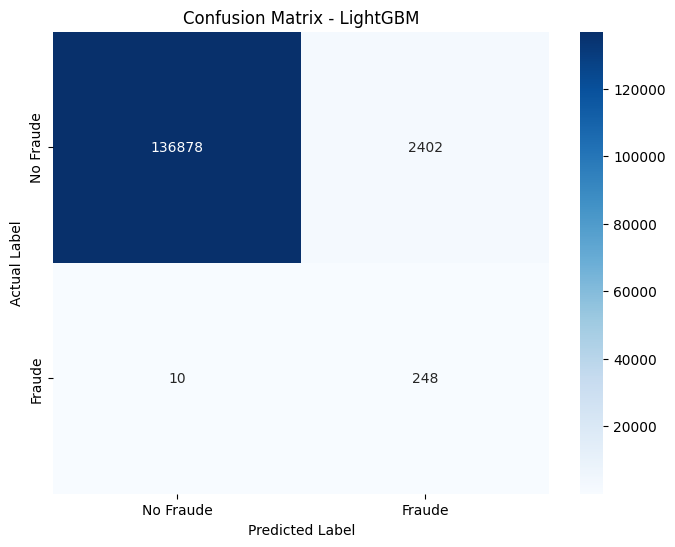

In [22]:
cm = confusion_matrix(y_test, y_pred_binary_improved)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fraude', 'Fraude'], yticklabels=['No Fraude', 'Fraude'])
plt.title('Confusion Matrix - LightGBM')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

### Métrica usando la frecuencia de compra a un vendedor

In [23]:
def custom_merchant_frequency_metric(preds, dataset):
    """
    Función personalizada para evaluar la efectividad del modelo
    en la detección de fraudes basados en patrones inusuales de frecuencia
    de compra entre un usuario y un comerciante.
    """
    # Obtenemos las etiquetas verdaderas
    labels = dataset.get_label()
    
    # Convertimos las predicciones a clases binarias
    preds_binary = np.where(preds > 0.5, 1, 0)
    
    try:
        # Acceder a los datos originales
        data_to_use = X_train_processed if dataset.reference is None else X_test_processed
        
        # Características importantes para analizar frecuencia usuario-vendedor
        first_time = data_to_use['first_time_at_merchant'].values
        high_amt_first = data_to_use['high_amt_first_time'].values
        times_day_z = data_to_use['times_day_z_score'].values
        
        # Identificar transacciones potencialmente sospechosas por frecuencia
        suspicious_frequency = (first_time == 1) | (high_amt_first == 1) | (times_day_z > 2.0)
        
        # Calcular métricas específicas para patrón de frecuencia inusual
        true_pos_freq = np.sum((labels == 1) & (preds_binary == 1) & suspicious_frequency)
        false_neg_freq = np.sum((labels == 1) & (preds_binary == 0) & suspicious_frequency)
        
        # Calcular el recall en transacciones con frecuencia sospechosa
        if true_pos_freq + false_neg_freq > 0:
            frequency_recall = true_pos_freq / (true_pos_freq + false_neg_freq)
        else:
            frequency_recall = 1.0  # No hay casos sospechosos
        
        # Calculamos las métricas generales
        true_positives = np.sum((labels == 1) & (preds_binary == 1))
        false_positives = np.sum((labels == 0) & (preds_binary == 1))
        
        # Calcular precisión para fraudes en general
        if true_positives + false_positives > 0:
            precision = true_positives / (true_positives + false_positives)
        else:
            precision = 0.0
            
        # Métrica combinada: Balance entre precisión general y recall en casos sospechosos
        # Ponderamos más el recall en casos sospechosos por frecuencia (0.7 vs 0.3)
        weighted_score = 0.3 * precision + 0.7 * frequency_recall
        
        # Invertimos el score para que un valor menor sea mejor (para optimización)
        inverted_score = 1.0 - weighted_score
        
        return 'merchant_frequency_metric', inverted_score, False  # False porque un valor menor es mejor
        
    except (ValueError, IndexError):
        # Calculamos la métrica personalizada: FN / (TP + FN) en caso de error
        true_positives = np.sum((labels == 1) & (preds_binary == 1))
        false_negatives = np.sum((labels == 1) & (preds_binary == 0))
        
        if true_positives == 0:
            ratio = float('inf')  # Si no hay TP, la métrica es infinita (muy mala)
        else:
            ratio = (true_positives + false_negatives) / true_positives

        return 'merchant_frequency_metric', ratio, False  # Invertimos F1 para que menor sea mejor

In [24]:
# Configurar parámetros
params_fp = {
    'objective': 'binary', # Definimos el objetivo de clasificación binaria
    'metric': 'precision', # Definimos la métrica de evaluación a binar logloss por nuestro objetivo
    'learning_rate': 0.05, # Definimos la tasa de aprendizaje
    'num_leaves': 42, # Definimos el número de hojas de nuestros árboles
    'seed': 321, # Definimos la semilla para guardar el estado aleatorio
    'feature_fraction': 0.8, # Definimos la fracción de características a usar en cada iteración (estas son seleccionadas aleatoriamente)
    'lambda_l1': 0.6, # Definimos la regularización L1
    'lambda_l2': 0.7, # Definimos la regularización L2
    'is_unbalance': True, # Le indicamos al modelo que el dataset está desbalanceado
    'boosting_type': 'dart', # Definimos el tipo de boosting a usar (utilizamos DART, ya que es una opción más robusta, aunque más costosa y lenta al momento de entrenar datos)
    'num_threads': 4, # Definimos el número de hilos a usar para realizar el entrenamiento
}

# Entrenar el modelo con la métrica personalizada
model_fp = lgb.train(
    params_fp,
    train_data,
    num_boost_round=100,
    valid_sets=[train_data, test_data],
    feval=custom_merchant_frequency_metric
)

[LightGBM] [Info] Number of positive: 9393, number of negative: 1703463
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7131
[LightGBM] [Info] Number of data points in the train set: 1712856, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005484 -> initscore=-5.200454
[LightGBM] [Info] Start training from score -5.200454


In [25]:
# Obtenemos las predicciones del modelo mejorado con el dataset de prueba
y_pred_improved_fp = model_fp.predict(X_test_processed)
# Convertir a clases
y_pred_binary_improved_fp = np.where(y_pred_improved_fp > 0.5, 1, 0)

# Calcular las métricas
accuracy_fp = accuracy_score(y_test, y_pred_binary_improved_fp)
auc_fp = roc_auc_score(y_test, y_pred_improved_fp)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary_improved_fp, target_names=['Not Fraud', 'Fraud']))

print(f"Accuracy: {accuracy_fp:.4f}")
print(f"ROC AUC Score: {auc_fp:.4f}")


Classification Report:
              precision    recall  f1-score   support

   Not Fraud       1.00      0.99      0.99    139280
       Fraud       0.12      0.95      0.21       258

    accuracy                           0.99    139538
   macro avg       0.56      0.97      0.60    139538
weighted avg       1.00      0.99      0.99    139538

Accuracy: 0.9868
ROC AUC Score: 0.9956


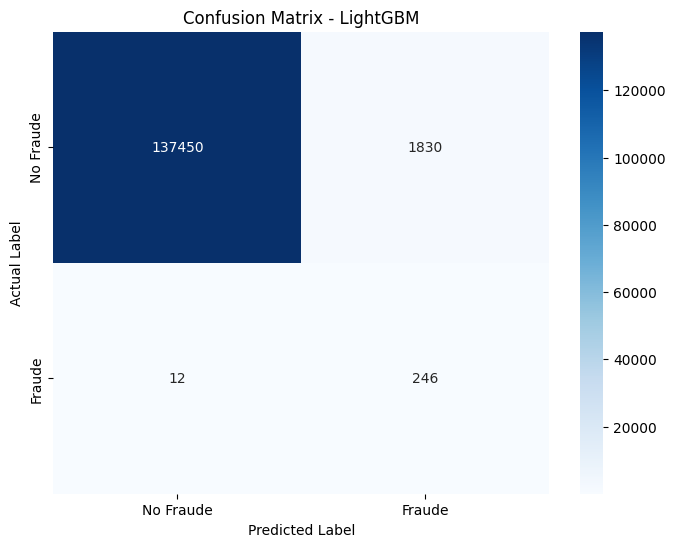

In [26]:
cm = confusion_matrix(y_test, y_pred_binary_improved_fp)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fraude', 'Fraude'], yticklabels=['No Fraude', 'Fraude'])
plt.title('Confusion Matrix - LightGBM')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

### Métrica identificando anomalías en distancias

In [27]:
def custom_distance_anomaly_metric(preds, dataset):
    """
    Función personalizada para evaluar la efectividad del modelo
    en la detección de fraudes basados en anomalías de distancia y velocidad.
    """
    # Obtenemos las etiquetas verdaderas
    labels = dataset.get_label()
    
    # Convertimos las predicciones a clases binarias
    preds_binary = np.where(preds > 0.5, 1, 0)
    
    try:
        # Accedemos a los datos originales
        data_to_use = X_train_processed if dataset.reference is None else X_test_processed
        
        # Características relacionadas con la distancia
        unusual_distance = data_to_use['unusual_distance'].values
        velocity_km_h = data_to_use['velocity_km_h'].values
        dist_z_score = data_to_use['dist_z_score'].values
        
        # Definimos umbrales para identificar anomalías
        velocity_threshold = 300  # km/h (velocidad imposible entre transacciones)
        z_score_threshold = 3.0   # Más de 3 desviaciones estándar es muy inusual
        
        # Identificar transacciones con anomalías de distancia
        distance_anomalies = (unusual_distance == 1) | \
                             (velocity_km_h > velocity_threshold) | \
                             (np.abs(dist_z_score) > z_score_threshold)
        
        # Calcular métricas específicas para anomalías de distancia
        true_pos_dist = np.sum((labels == 1) & (preds_binary == 1) & distance_anomalies)
        false_neg_dist = np.sum((labels == 1) & (preds_binary == 0) & distance_anomalies)
        false_pos_dist = np.sum((labels == 0) & (preds_binary == 1) & distance_anomalies)
        
        # Calcular métricas generales
        true_positives = np.sum((labels == 1) & (preds_binary == 1))
        false_positives = np.sum((labels == 0) & (preds_binary == 1))
        false_negatives = np.sum((labels == 1) & (preds_binary == 0))
        
        # Calcular recall específico para anomalías de distancia
        if true_pos_dist + false_neg_dist > 0:
            distance_recall = true_pos_dist / (true_pos_dist + false_neg_dist)
        else:
            distance_recall = 1.0  # No hay anomalías de distancia con fraude
        
        # Calcular precisión específica para anomalías de distancia
        if true_pos_dist + false_pos_dist > 0:
            distance_precision = true_pos_dist / (true_pos_dist + false_pos_dist)
        else:
            distance_precision = 1.0  # No hay predicciones positivas para anomalías
        
        # Calcular recall general
        if true_positives + false_negatives > 0:
            general_recall = true_positives / (true_positives + false_negatives)
        else:
            general_recall = 0.0
            
        # Calcular precisión general
        if true_positives + false_positives > 0:
            general_precision = true_positives / (true_positives + false_positives)
        else:
            general_precision = 0.0
        
        # Calcular F1-score para anomalías de distancia
        if distance_precision + distance_recall > 0:
            distance_f1 = 2 * (distance_precision * distance_recall) / (distance_precision + distance_recall)
        else:
            distance_f1 = 0.0
        
        # Métrica combinada: Balance entre métricas generales y específicas de distancia
        # Damos más peso a la detección de anomalías de distancia
        weighted_score = 0.3 * general_precision + 0.2 * general_recall + 0.5 * distance_f1
        
        # Invertimos para que un valor menor sea mejor (para optimización)
        inverted_score = 1.0 - weighted_score
        
        return 'distance_anomaly_metric', inverted_score, False  # False porque un valor menor es mejor
    
    except (ValueError, IndexError, KeyError) as e:
        # Calculamos la métrica personalizada: FN / (TP + FN) en caso de error
        true_positives = np.sum((labels == 1) & (preds_binary == 1))
        false_negatives = np.sum((labels == 1) & (preds_binary == 0))
        
        if true_positives == 0:
            ratio = float('inf')  # Si no hay TP, la métrica es infinita (muy mala)
        else:
            ratio = (true_positives + false_negatives) / true_positives
        
        return 'distance_anomaly_metric', ratio, False

In [28]:
# Configurar parámetros
params_fn = {
    'objective': 'binary', # Definimos el objetivo de clasificación binaria
    'metric': 'binary_logloss', # Definimos la métrica de evaluación a binar logloss por nuestro objetivo
    'learning_rate': 0.05, # Definimos la tasa de aprendizaje
    'num_leaves': 31, # Definimos el número de hojas de nuestros árboles
    'max_depth': 10, # Definimos la profundidad máxima de nuestros árboles
    'seed': 321, # Definimos la semilla para guardar el estado aleatorio
    'feature_fraction': 0.6, # Definimos la fracción de características a usar en cada iteración (estas son seleccionadas aleatoriamente)
    'lambda_l1': 0.5, # Definimos la regularización L1
    'lambda_l2': 0.7, # Definimos la regularización L2
    'is_unbalance': True, # Le indicamos al modelo que el dataset está desbalanceado
    'boosting_type': 'dart', # Definimos el tipo de boosting a usar (utilizamos DART, ya que es una opción más robusta, aunque más costosa y lenta al momento de entrenar datos)
    'num_threads': 4, # Definimos el número de hilos a usar para realizar el entrenamiento
}

# Entrenar el modelo con la métrica personalizada
model_fn = lgb.train(
    params_fn,
    train_data,
    num_boost_round=100,
    valid_sets=[train_data, test_data],
    feval=custom_distance_anomaly_metric,
)

[LightGBM] [Info] Number of positive: 9393, number of negative: 1703463
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7131
[LightGBM] [Info] Number of data points in the train set: 1712856, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005484 -> initscore=-5.200454
[LightGBM] [Info] Start training from score -5.200454


In [29]:
# Obtenemos las predicciones del modelo mejorado con el dataset de prueba
y_pred_improved_fn = model_fn.predict(X_test_processed)
# Convertir a clases
y_pred_binary_improved_fn = np.where(y_pred_improved_fn > 0.5, 1, 0)

# Calcular las métricas
accuracy_fn = accuracy_score(y_test, y_pred_binary_improved_fn)
auc_fn = roc_auc_score(y_test, y_pred_improved_fn)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary_improved_fn, target_names=['Not Fraud', 'Fraud']))

print(f"Accuracy: {accuracy_fn:.4f}")
print(f"AUC: {auc_fn:.4f}")


Classification Report:
              precision    recall  f1-score   support

   Not Fraud       1.00      0.98      0.99    139280
       Fraud       0.10      0.96      0.19       258

    accuracy                           0.98    139538
   macro avg       0.55      0.97      0.59    139538
weighted avg       1.00      0.98      0.99    139538

Accuracy: 0.9844
AUC: 0.9958


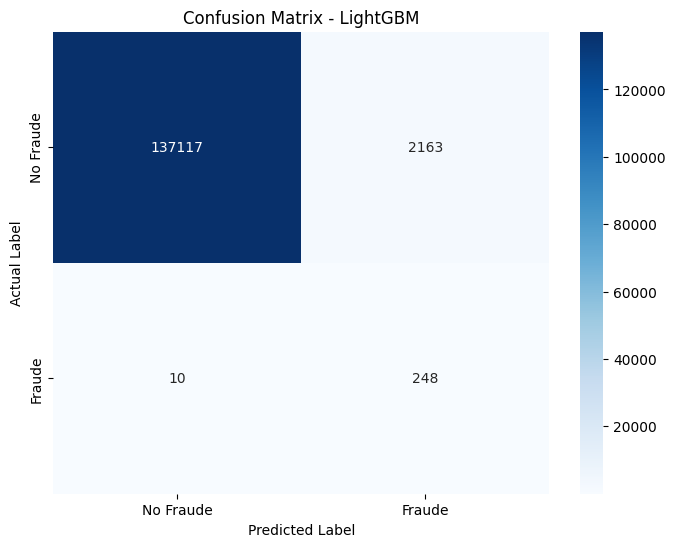

In [30]:
# Desplegamos las predicciones en una matriz de confusión
cm = confusion_matrix(y_test, y_pred_binary_improved_fn)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fraude', 'Fraude'], yticklabels=['No Fraude', 'Fraude'])
plt.title('Confusion Matrix - LightGBM')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

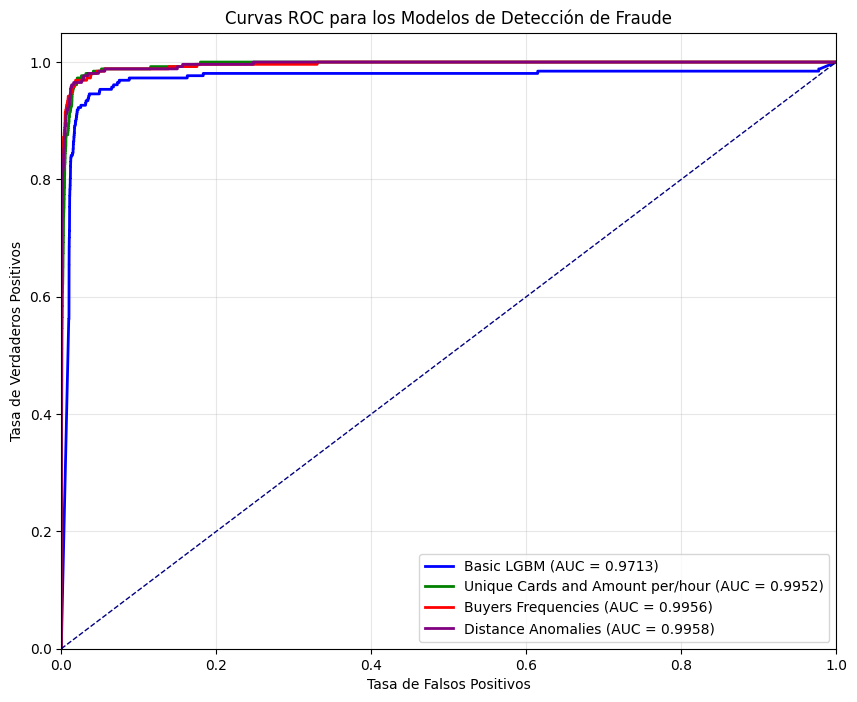

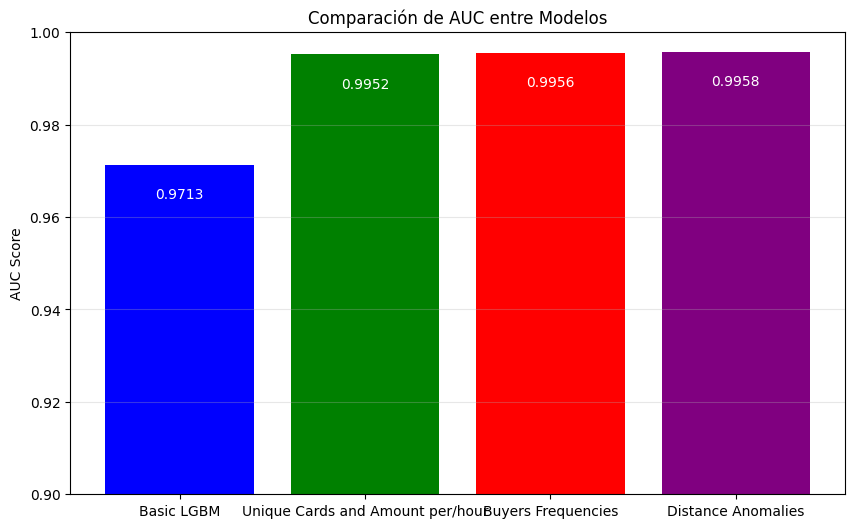

In [31]:
# Add this cell after your model evaluation
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Create figure with larger size
plt.figure(figsize=(10, 8))

# Calculate ROC curve for all three models
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_pred_proba_lgbm)
fpr_improved, tpr_improved, _ = roc_curve(y_test, y_pred_improved)
fpr_fp, tpr_fp, _ = roc_curve(y_test, y_pred_improved_fp)
fpr_fn, tpr_fn, _ = roc_curve(y_test, y_pred_improved_fn)

# Calculate AUC for each model (you already have these values calculated)
roc_auc_lgbm = roc_auc_score(y_test, y_pred_proba_lgbm)
roc_auc_improved = roc_auc_score(y_test, y_pred_improved)
roc_auc_fp = roc_auc_score(y_test, y_pred_improved_fp)
roc_auc_fn = roc_auc_score(y_test, y_pred_improved_fn)

# Plot ROC curves
plt.plot(fpr_lgbm, tpr_lgbm, color='blue', lw=2, 
         label=f'Basic LGBM (AUC = {roc_auc_lgbm:.4f})')
plt.plot(fpr_improved, tpr_improved, color='green', lw=2, 
         label=f'Unique Cards and Amount per/hour (AUC = {roc_auc_improved:.4f})')
plt.plot(fpr_fp, tpr_fp, color='red', lw=2, 
         label=f'Buyers Frequencies (AUC = {roc_auc_fp:.4f})')
plt.plot(fpr_fn, tpr_fn, color='purple', lw=2, 
         label=f'Distance Anomalies (AUC = {roc_auc_fn:.4f})')

# Plot diagonal line (represents random classifier)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')

# Set labels and title
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC para los Modelos de Detección de Fraude')

# Add legend
plt.legend(loc='lower right')

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Set axis limits
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.show()

# You can also create a bar chart to compare AUC scores
plt.figure(figsize=(10, 6))
models = ['Basic LGBM', 'Unique Cards and Amount per/hour', 'Buyers Frequencies', 'Distance Anomalies']
auc_scores = [roc_auc_lgbm, roc_auc_improved, roc_auc_fp, roc_auc_fn]

# Create bar chart
bars = plt.bar(models, auc_scores, color=['blue', 'green', 'red', 'purple'])

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height - 0.005, # Adjust y-coordinate
             f'{height:.4f}', ha='center', va='top', color='white') # Change va to 'top' and set color for visibility

plt.ylim(0.9, 1.0)  # Adjust y-limit to focus on the differences
plt.title('Comparación de AUC entre Modelos')
plt.ylabel('AUC Score')
plt.grid(axis='y', alpha=0.3)
plt.show()